### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import numba
from concurrent.futures import ThreadPoolExecutor

### Classes

In [3]:
class DecisionTreeNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
        self.feature_index = feature_index  # index for the feature to split on
        self.threshold = threshold          # threshold value for the split
        self.left = left                    # left subtree
        self.right = right                  # right subtree
        self.value = value                  # class label for leaf node


class DecisionTreeClassifierScratch:
    def __init__(self, max_depth=10, min_samples_split=2, criterion='entropy'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.root = None
        
    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.root = self._build_tree(X, y)
        
    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        return -np.sum(probs * np.log2(probs))
    
    def _gini(self,y):
        _, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        return 1 - np.sum(probs ** 2)
    
    def _best_split(self, X, y):
        """
        Plan : Get number of records and number of features
        For each feature consider all unique values as threshold
        For each threshold, split the data into left and right
        Plan changed : from all threshold to the medain as threshold
        Calculate the impurity of the split
        Return the best split
        """
        m, n_features = X.shape   
        if m < self.min_samples_split:
            return None, None
        
        best_impurity = np.inf
        best_feature, best_threshold = None, None

        def split_data(X, y, feature, threshold):
            left_mask = X[:, feature] <= threshold
            right_mask = X[:, feature] > threshold
            return X[left_mask], X[right_mask], y[left_mask], y[right_mask]
        
        for feature in range(n_features):
            threshold = np.median(X[:, feature])
            left_X, right_X, left_y, right_y = split_data(X, y, feature, threshold)
            if len(left_y) < self.min_samples_split or len(right_y) < self.min_samples_split:
                continue

            weighted_impurity = (len(left_y) * self._entropy(left_y) + len(right_y) * self._entropy(right_y)) / m

            if weighted_impurity < best_impurity:
                best_impurity = weighted_impurity
                best_feature = feature
                best_threshold = threshold

        return best_feature, best_threshold
        #     for threshold in thresholds:
        #         left_mask = X[:, feature] <= threshold
        #         right_mask = X[:, feature] > threshold
                
        #         if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
        #             continue
                
        #         if self.criterion == 'entropy':
        #             impurity_left = self._entropy(y[left_mask])
        #             impurity_right = self._entropy(y[right_mask])
        #         else:
        #             impurity_left = self._gini(y[left_mask])
        #             impurity_right = self._gini(y[right_mask])
                
        #         weighted_impurity = (len(y[left_mask]) * impurity_left + len(y[right_mask]) * impurity_right) / m
                
        #         if weighted_impurity < best_impurity:
        #             best_impurity = weighted_impurity
        #             best_feature = feature
        #             best_threshold = threshold
                    
        # return best_feature, best_threshold

   

    
    def _build_tree(self, X, y, depth=0):
        num_samples = X.shape[0]
        num_labels = len(np.unique(y))
        
        # stopping criteria
        if depth >= self.max_depth or num_labels == 1 or num_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return DecisionTreeNode(value=leaf_value)
        
        feature, threshold = self._best_split(X, y)
        if feature is None:
            leaf_value = self._most_common_label(y)
            return DecisionTreeNode(value=leaf_value)
        
        left_indices = X[:, feature] <= threshold
        right_indices = X[:, feature] > threshold
        
        left = self._build_tree(X[left_indices], y[left_indices], depth+1)
        right = self._build_tree(X[right_indices], y[right_indices], depth+1)
        
        return DecisionTreeNode(feature_index=feature, threshold=threshold, left=left, right=right)
    
    def _most_common_label(self, y):
        counts = np.bincount(y)
        return np.argmax(counts)
    
    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])


In [4]:
class Data:
    def __init__(self):
        self.data = None

    def load_data(self, file_path):
        self.data = pd.read_csv(file_path)

    def encode_categorical(self):
        if self.data is not None:
            for col in self.data.select_dtypes(include=['object']):
                le = LabelEncoder()
                self.data[col] = le.fit_transform(self.data[col].astype(str))
   


    def list_features(self):
        if self.data is not None:
            return self.data.columns.tolist()
        else:
            return []
        
    def display_data_with_dummies(self):
        if self.data is not None:
            display(pd.get_dummies(self.data))

    def plot_feature(self, feature, plot_type='histogram'):
        if self.data is not None and feature in self.data.columns:
            if plot_type == 'histogram':
                self.data[feature].hist(figsize=(6, 4))
                plt.title(f"Histogram for {feature}")
            elif plot_type == 'boxplot':
                self.data[feature].plot(kind='box', figsize=(6, 4))
                plt.title(f"Boxplot for {feature}")
            elif plot_type == 'violinplot':
                sns.violinplot(y=self.data[feature])
                plt.title(f"Violin Plot for {feature}")
            else:
                print(f"Plot type {plot_type} is not supported.")
            plt.show()

    def split_data(self, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
        if self.data is not None:
            train_temp, test = train_test_split(self.data, test_size=test_size, random_state=random_state)
            val_portion = val_size / (train_size + val_size)
            train, val = train_test_split(train_temp, test_size=val_portion, random_state=random_state)
            train, val , test = np.array(train), np.array(val), np.array(test)
            return train, val, test

### Loading Dataset

In [5]:
# Loading the Dataset

data_obj_train = Data()
data_obj_train.load_data('SMAI/train_data.csv')

data_obj_val = Data()
data_obj_val.load_data('SMAI/val_data.csv')

data_obj_test = Data()
data_obj_test.load_data('SMAI/test_data.csv')


In [6]:
def handle_missing(data, strategy='most_frequent'):
    # if data is not None:
    #     for col in data.columns:
    #         non_zero_data = data[data[col] != 0][col]
    #         if strategy == 'most_frequent':
    #             # Find the most frequent value in the column excluding zeros
    #             fill_value = non_zero_data.mode()[0]
    #         elif strategy == 'mean':
    #             # Compute the mean of the column excluding zeros (for numerical data)
    #             fill_value = non_zero_data.mean()
    #         elif strategy == 'median':
    #             # Compute the median of the column excluding zeros (for numerical data)
    #             fill_value = non_zero_data.median()
    #         elif strategy == 'constant':
    #             # Set a constant fill value (can be modified)
    #             fill_value = 0
    #         else:
    #             raise ValueError("Invalid strategy. Choose from 'most_frequent', 'mean', 'median', or 'constant'.")

    #         # Fill zero values in the column
    #         data[col].replace(0, fill_value, inplace=True)
    # else:
    #     print("No data to handle missing values.")
    return data

### Dropping Unnecessary Features

##### Train Data

In [7]:
#Dropping the unnecessary features
X_train = data_obj_train.data

X_train = X_train.drop(columns=['Address','FLAG'])
X_features = np.array(X_train.columns.to_list())
y_train = data_obj_train.data['FLAG']
X_train = handle_missing(X_train, strategy='most_frequent')
X_train = X_train.to_numpy()
# X_train, dropped_indices = DecisionTreeNode.remove_unnecessary_features(X_train, corr_threshold=0.8)
# print("Removed features:", X_features[dropped_indices])
print("X_train shape after removing unnecessary features:", X_train.shape)

X_train shape after removing unnecessary features: (9059, 12)


##### Validation Data

In [8]:
X_val = data_obj_val.data
X_val = X_val.drop(columns=['Address','FLAG'])
X_val = handle_missing(X_val, strategy='most_frequent')
X_val = X_val.to_numpy()
# X_val = np.delete(X_val, dropped_indices, axis=1)
y_val = data_obj_val.data['FLAG']
# X_val, dropped_indices = DecisionTreeNode.remove_unnecessary_features(X_val, corr_threshold=0.8)
# print("Removed features:", X_features[dropped_indices])
# print("X_val shape after removing unnecessary features:", X_val.shape)


##### Test Data

In [9]:
X_test = data_obj_test.data
X_test = X_test.drop(columns=['Address','FLAG'])
X_test = handle_missing(X_test, strategy='most_frequent')
X_test = X_test.to_numpy()
# X_test = np.delete(X_test, dropped_indices, axis=1)
y_test = data_obj_test.data['FLAG']
# X_test, dropped_indices = DecisionTreeNode.remove_unnecessary_features(X_test, corr_threshold=0.8)
# print("Removed features:", X_features[dropped_indices])
# print("X_test shape after removing unnecessary features:", X_test.shape)

### Plotting Correlation Matrix and Violin Plots

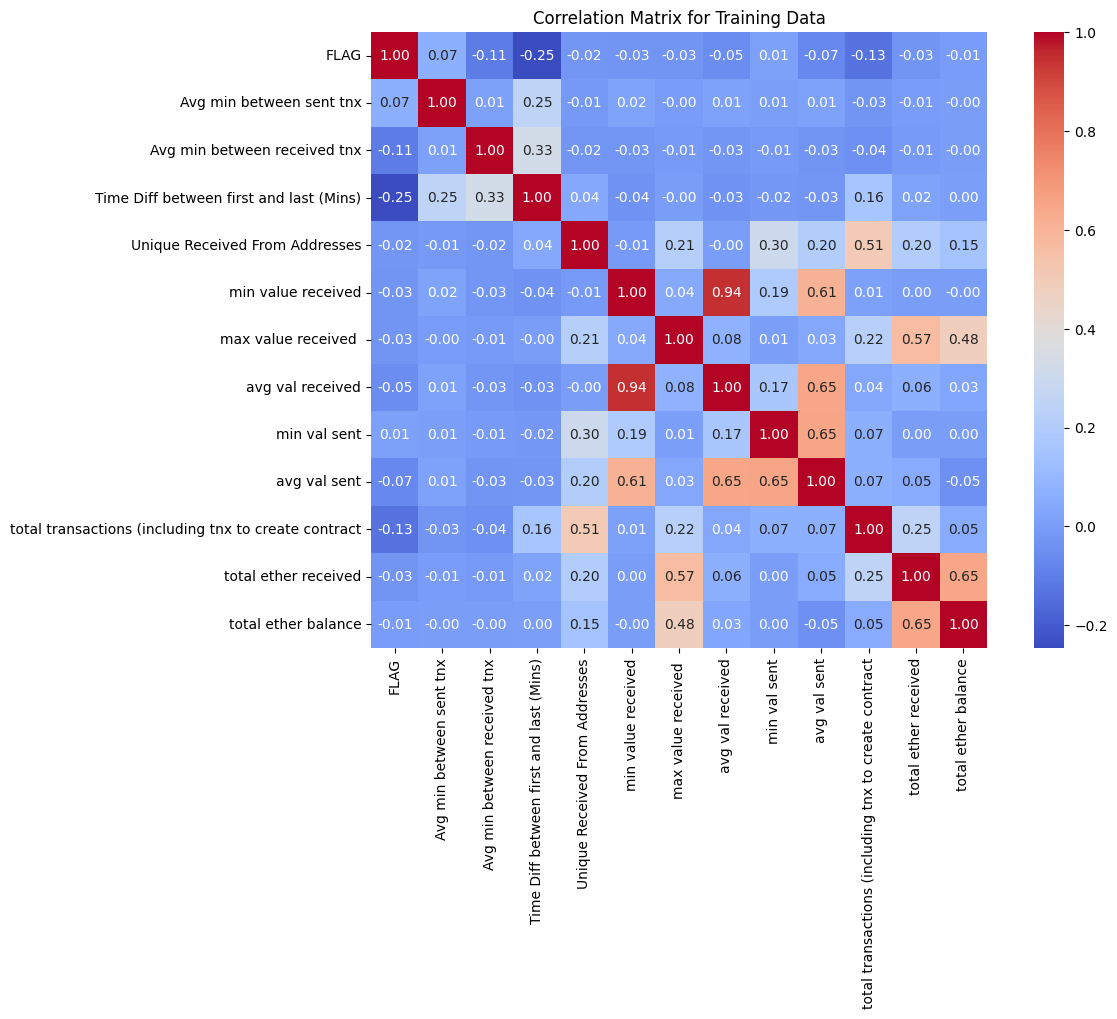

In [10]:
def plot_correlation_matrix(data, title='Correlation Matrix'):
    """
    Plots the correlation matrix for the given data.

    Parameters:
        data (pd.DataFrame or np.ndarray): The data for which to plot the correlation matrix.
        title (str): The title of the plot.
    """
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, columns=X_features)
    
    corr_matrix = data.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
    plt.title(title)
    plt.show()

correlation_data = data_obj_train.data
correlation_data = correlation_data.drop(columns=['Address'])
plot_correlation_matrix(correlation_data, title='Correlation Matrix for Training Data')

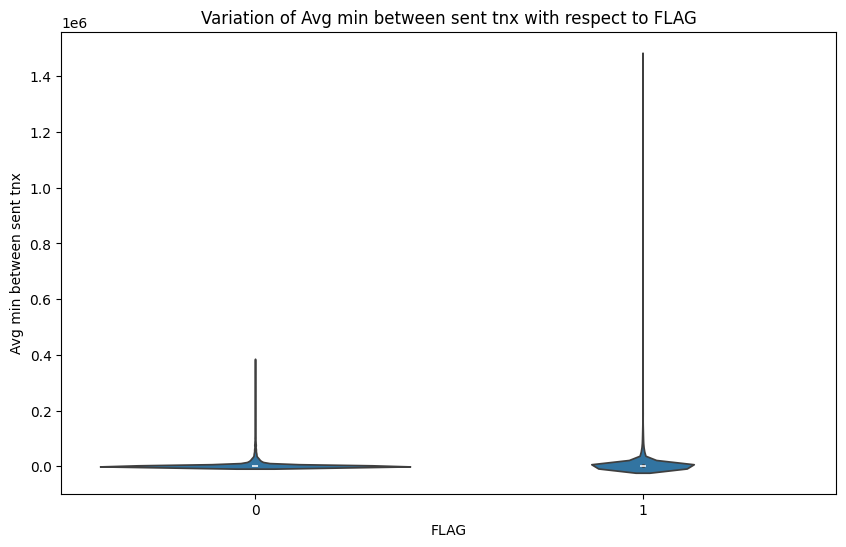

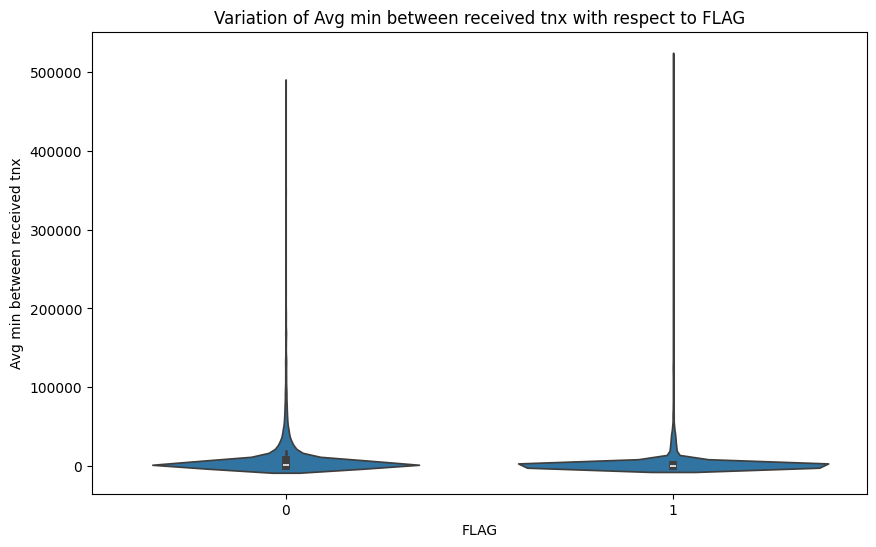

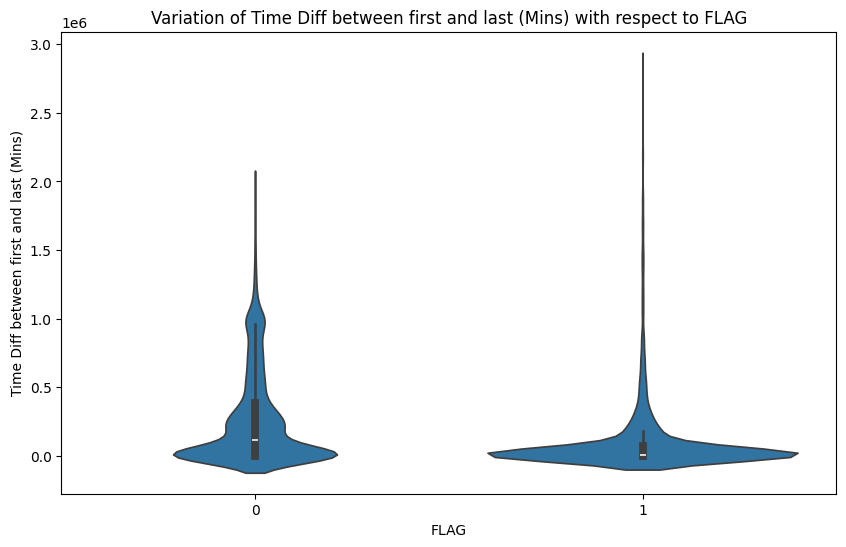

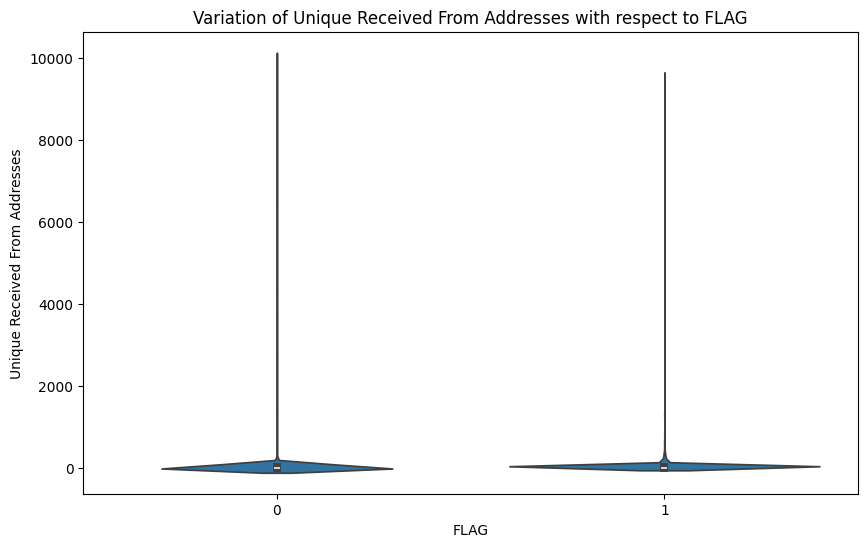

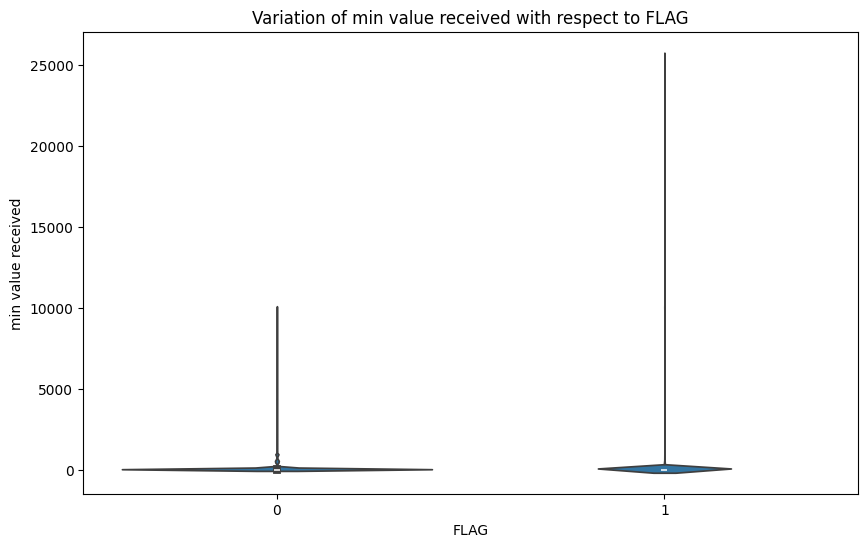

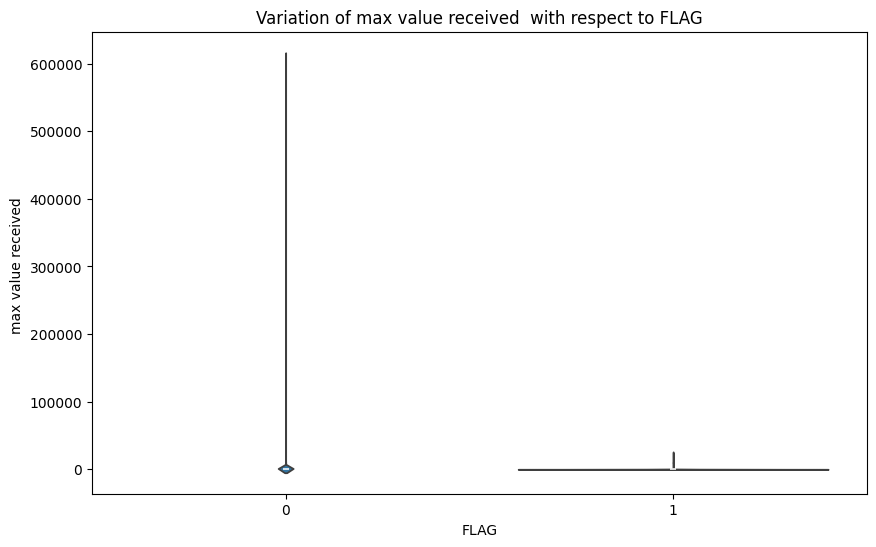

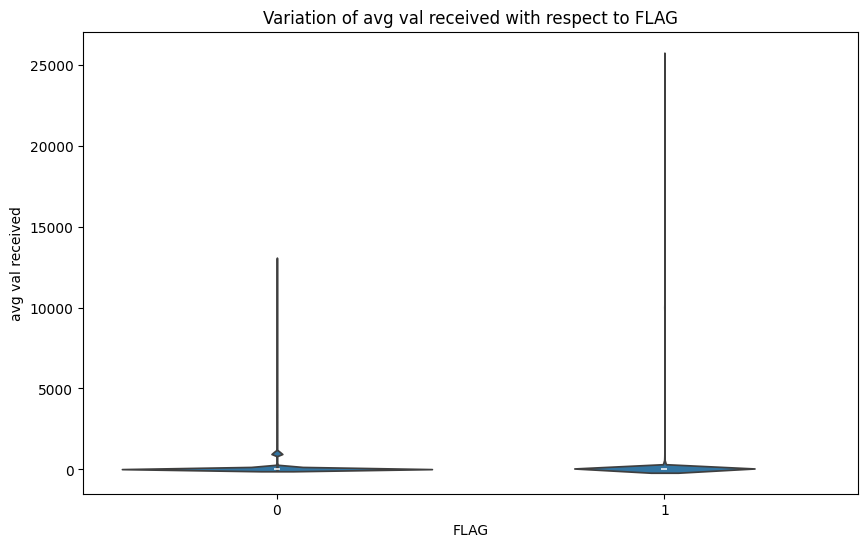

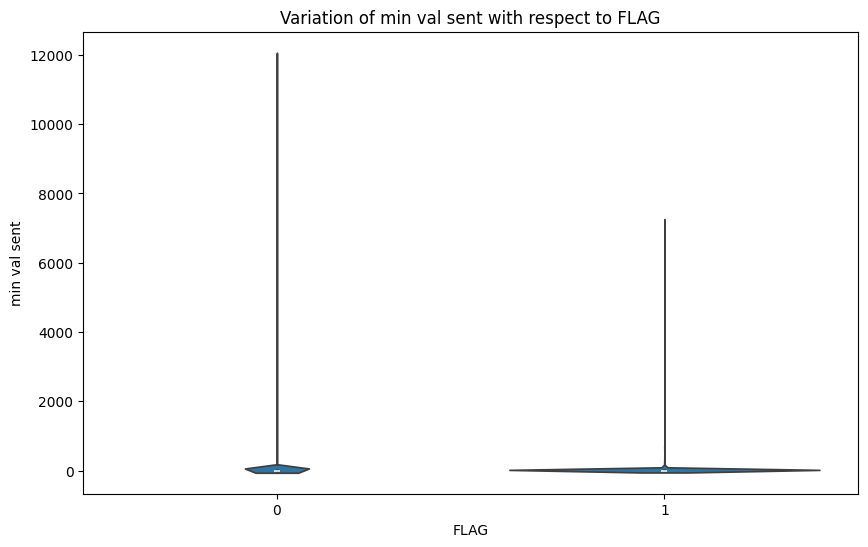

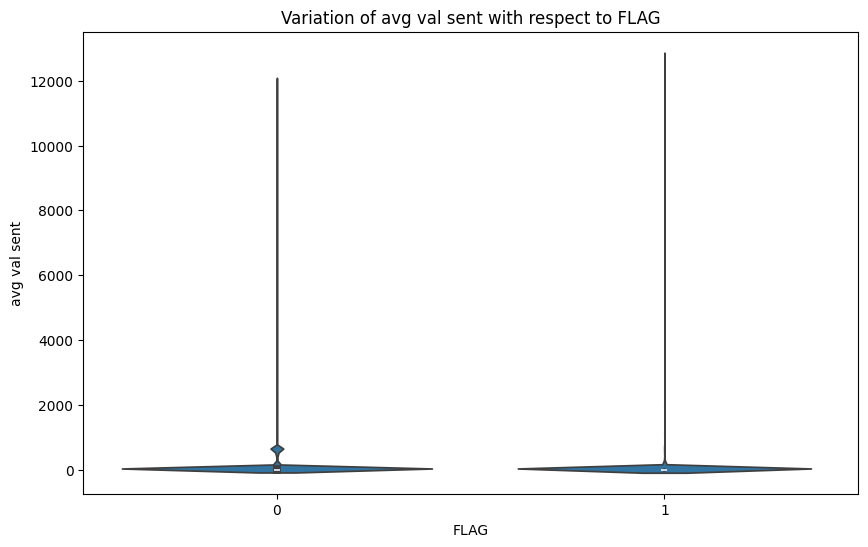

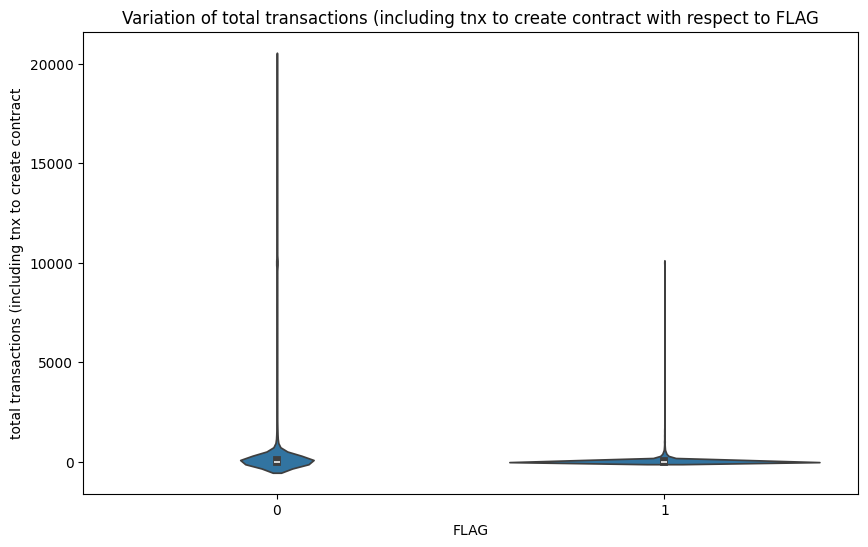

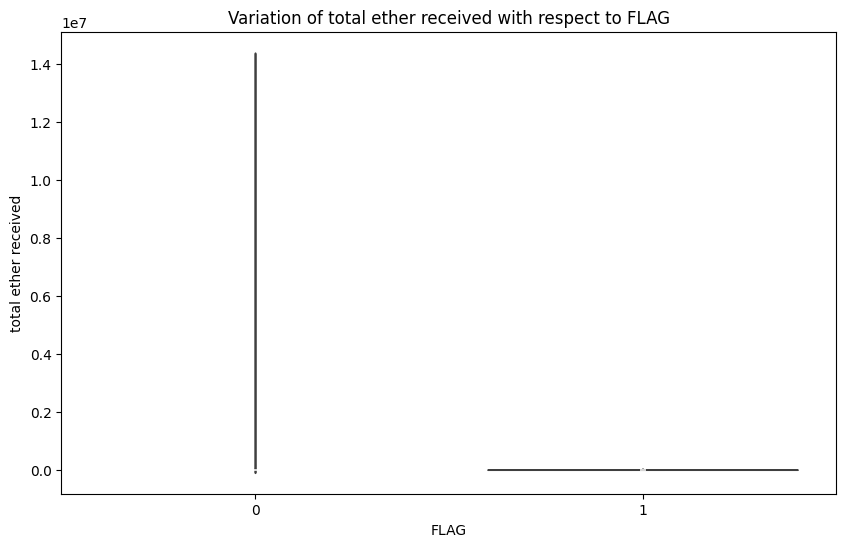

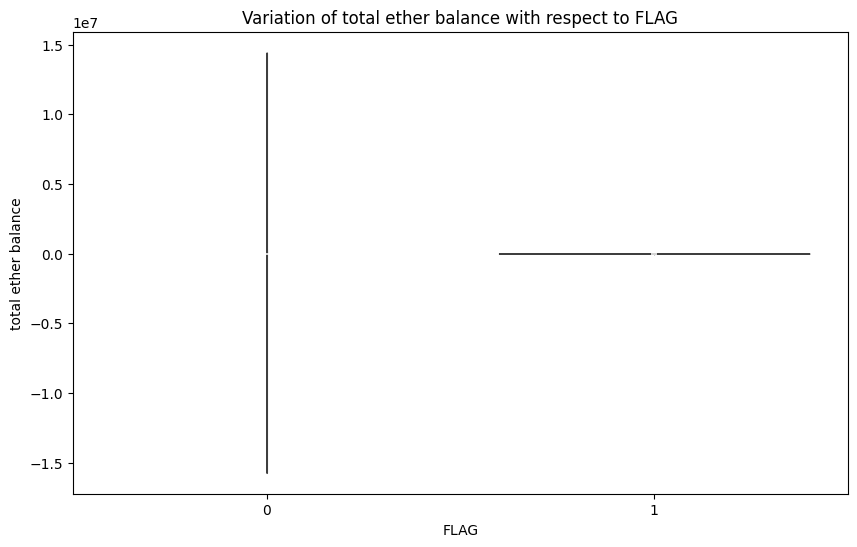

In [11]:
def plot_violin_with_flag(data, flag_column='FLAG'):
    """
    Plots the variation of other columns with respect to the FLAG column using a violin plot.

    Parameters:
        data (pd.DataFrame): The data containing the features and the FLAG column.
        flag_column (str): The name of the FLAG column.
    """
    features = [col for col in data.columns if col != flag_column]
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.violinplot(x=flag_column, y=feature, data=data)
        plt.title(f'Variation of {feature} with respect to {flag_column}')
        plt.show()

# Example usage:
plot_violin_with_flag(correlation_data)

#### Observations:
FLAG has low correlations with most features
Highest correlation being time diff between first and last transaction
And for this feature of time diff the variance wrt flag also shows variable distribution unlike others.

### Using Implemented Decision Tree on given data and comparing with scikit

In [12]:
def compare_scratch_and_sciket_learn(X_train, y_train, X_val, y_val, X_test, y_test, criteria='entropy'):
    """
    Compares the performance of the DecisionTreeClassifier implemented from scratch with the one from scikit-learn.

    Parameters:
        X_train (np.ndarray): The training features.
        y_train (np.ndarray): The training labels.
        X_val (np.ndarray): The validation features.
        y_val (np.ndarray): The validation labels.
        X_test (np.ndarray): The test features.
        y_test (np.ndarray): The test labels.
    """
    # Train the model implemented from scratch


    print(f"Using criterion: {criteria}")
    import time
    start_scratch_time = time.time()
    scratch_model = DecisionTreeClassifierScratch(max_depth=7, min_samples_split=5, criterion=criteria)
    scratch_model.fit(X_train, y_train)
    scratch_train_acc = (scratch_model.predict(X_train) == y_train).mean()
    scratch_val_acc = (scratch_model.predict(X_val) == y_val).mean()
    scratch_test_acc = (scratch_model.predict(X_test) == y_test).mean()
    print(f"Accuracy of the scratch model on the training data: {scratch_train_acc:.4f}")
    print(f"Accuracy of the scratch model on the validation data: {scratch_val_acc:.4f}")
    print(f"Accuracy of the scratch model on the test data: {scratch_test_acc:.4f}")
    end_scratch_time = time.time() - start_scratch_time

    # Train the model using scikit-learn
    from sklearn.tree import DecisionTreeClassifier
    sklearn_start_time= time.time()
    sklearn_model = DecisionTreeClassifier(max_depth=7, min_samples_split=5, criterion=criteria)
    sklearn_model.fit(X_train, y_train)
    sklearn_train_acc = sklearn_model.score(X_train, y_train)
    sklearn_val_acc = sklearn_model.score(X_val, y_val)
    sklearn_test_acc = sklearn_model.score(X_test, y_test)
    print(f"Accuracy of the scikit-learn model on the training data: {sklearn_train_acc:.4f}")
    print(f"Accuracy of the scikit-learn model on the validation data: {sklearn_val_acc:.4f}")
    print(f"Accuracy of the scikit-learn model on the test data: {sklearn_test_acc:.4f}")
    sklearn_end_time = time.time() - sklearn_start_time

    print(f"Time taken by the scratch model: {end_scratch_time:.4f} seconds")
    print(f"Time taken by the scikit-learn model: {sklearn_end_time:.4f} seconds")


In [13]:
### Using DecisionTreeClassifierScratch for X_train and y_train and X_val and y_val
dt = DecisionTreeClassifierScratch(max_depth=7, min_samples_split=5, criterion='entropy')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)

unique, counts = np.unique(y_val, return_counts=True)
print("Unique values in y_val and their frequency:", dict(zip(unique, counts)))
accuracy = np.mean(y_pred == y_val) * 100
print(f"Validation Accuracy: {accuracy:.2f}%")

Unique values in y_val and their frequency: {0: 1220, 1: 1045}
Validation Accuracy: 88.61%


In [14]:
compare_scratch_and_sciket_learn(X_train, y_train, X_val, y_val, X_test, y_test, criteria='entropy')
compare_scratch_and_sciket_learn(X_train, y_train, X_val, y_val, X_test, y_test, criteria='gini')

Using criterion: entropy
Accuracy of the scratch model on the training data: 0.8829
Accuracy of the scratch model on the validation data: 0.8861
Accuracy of the scratch model on the test data: 0.8933
Accuracy of the scikit-learn model on the training data: 0.8915
Accuracy of the scikit-learn model on the validation data: 0.8808
Accuracy of the scikit-learn model on the test data: 0.8944
Time taken by the scratch model: 0.2300 seconds
Time taken by the scikit-learn model: 0.0544 seconds
Using criterion: gini
Accuracy of the scratch model on the training data: 0.8829
Accuracy of the scratch model on the validation data: 0.8861
Accuracy of the scratch model on the test data: 0.8933
Accuracy of the scikit-learn model on the training data: 0.9090
Accuracy of the scikit-learn model on the validation data: 0.8834
Accuracy of the scikit-learn model on the test data: 0.9022
Time taken by the scratch model: 0.1461 seconds
Time taken by the scikit-learn model: 0.0405 seconds


### Hyperparameter calculation

Results for criterion = entropy
  max_depth=2, min_samples_split=2: val_acc=0.7095
  max_depth=2, min_samples_split=5: val_acc=0.7095
  max_depth=2, min_samples_split=10: val_acc=0.7095
  max_depth=5, min_samples_split=2: val_acc=0.8552
  max_depth=5, min_samples_split=5: val_acc=0.8552
  max_depth=5, min_samples_split=10: val_acc=0.8552
  max_depth=7, min_samples_split=2: val_acc=0.8861
  max_depth=7, min_samples_split=5: val_acc=0.8861
  max_depth=7, min_samples_split=10: val_acc=0.8861
  max_depth=10, min_samples_split=2: val_acc=0.8892
  max_depth=10, min_samples_split=5: val_acc=0.8918
  max_depth=10, min_samples_split=10: val_acc=0.8927
  max_depth=12, min_samples_split=2: val_acc=0.8865
  max_depth=12, min_samples_split=5: val_acc=0.8918
  max_depth=12, min_samples_split=10: val_acc=0.8954
Results for criterion = gini
  max_depth=2, min_samples_split=2: val_acc=0.7095
  max_depth=2, min_samples_split=5: val_acc=0.7095
  max_depth=2, min_samples_split=10: val_acc=0.7095
  max_dep

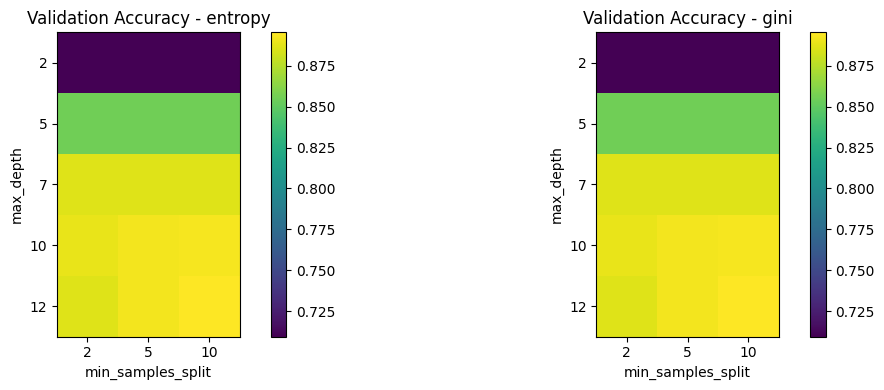

In [15]:
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt

def evaluate_tree(max_depth, min_samples_split, criterion, X_train, y_train, X_val, y_val):
    """
    Trains and evaluates a DecisionTreeClassifierScratch with the given parameters.
    Returns the validation accuracy.
    """
    clf = DecisionTreeClassifierScratch(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        criterion=criterion
    )
    clf.fit(X_train, y_train)
    y_pred_val = clf.predict(X_val)
    val_acc = (y_pred_val == y_val).mean()
    return val_acc

def grid_search_decision_tree_scratch(
    max_depth_list, min_samples_split_list, criteria_list, 
    X_train, y_train, X_val, y_val
):
    """
    Performs parallel grid search over the given hyperparameters using DecisionTreeClassifierScratch.
    Returns a nested dictionary of validation accuracies of the form:
    results[criterion][(max_depth, min_samples_split)] = val_acc
    """
    results = {c: {} for c in criteria_list}

    # Create all combinations of parameters
    param_combinations = [
        (md, ms, c) 
        for c in criteria_list 
        for md in max_depth_list 
        for ms in min_samples_split_list
    ]

    # Evaluate in parallel
    eval_results = Parallel(n_jobs=-1)(
        delayed(evaluate_tree)(md, ms, c, X_train, y_train, X_val, y_val)
        for (md, ms, c) in param_combinations
    )

    # Store results in a nested dictionary
    for (md, ms, c), val_acc in zip(param_combinations, eval_results):
        results[c][(md, ms)] = val_acc

    return results

# Example usage:
max_depth_list = [2, 5, 7, 10, 12]            # Modify as needed
min_samples_split_list = [2, 5, 10]   # Modify as needed
criteria_list = ['entropy', 'gini']

# Perform parallel grid search
results = grid_search_decision_tree_scratch(
    max_depth_list, 
    min_samples_split_list, 
    criteria_list,
    X_train, 
    y_train, 
    X_val, 
    y_val
)

# 'results' is now a nested dictionary: 
#   results[criterion][(max_depth, min_samples_split)] = val_accuracy

# Print or plot the results
for criterion in criteria_list:
    print(f"Results for criterion = {criterion}")
    for (md, ms), val_acc in results[criterion].items():
        print(f"  max_depth={md}, min_samples_split={ms}: val_acc={val_acc:.4f}")

# Example: plot heatmap for each criterion
fig, axes = plt.subplots(1, len(criteria_list), figsize=(12, 4))
for idx, criterion in enumerate(criteria_list):
    # Initialize matrix of shape (len(max_depth_list), len(min_samples_split_list))
    val_matrix = np.zeros((len(max_depth_list), len(min_samples_split_list)))
    for i, md in enumerate(max_depth_list):
        for j, ms in enumerate(min_samples_split_list):
            val_matrix[i, j] = results[criterion][(md, ms)]
    
    ax = axes[idx]
    im = ax.imshow(val_matrix, cmap='viridis')
    ax.set_xticks(np.arange(len(min_samples_split_list)))
    ax.set_yticks(np.arange(len(max_depth_list)))
    ax.set_xticklabels(min_samples_split_list)
    ax.set_yticklabels(max_depth_list)
    ax.set_xlabel('min_samples_split')
    ax.set_ylabel('max_depth')
    ax.set_title(f'Validation Accuracy - {criterion}')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

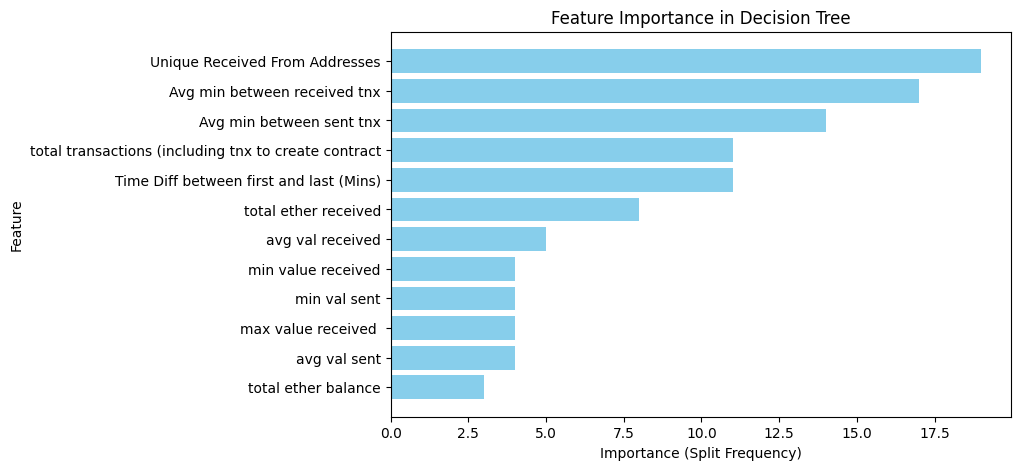

In [53]:
def compute_feature_importance(node, importance):
    """ Recursively traverse the tree and count feature usage. """
    if node is None:
        return

    if node.feature_index is not None:
        importance[node.feature_index] += 1  # Increment count for feature usage

    compute_feature_importance(node.left, importance)
    compute_feature_importance(node.right, importance)

def plot_feature_importance(root, feature_names):
    """ Compute and plot feature importance based on split frequency. """
    importance = Counter()
    compute_feature_importance(root, importance)

    if not importance:
        print("No feature importance found.")
        return

    sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    features, scores = zip(*sorted_features)

    plt.figure(figsize=(8, 5))
    plt.barh([feature_names[f] for f in features], scores, color='skyblue')
    plt.xlabel('Importance (Split Frequency)')
    plt.ylabel('Feature')
    plt.title('Feature Importance in Decision Tree')
    plt.gca().invert_yaxis()
    plt.show()

feature_names = X_features
plot_feature_importance(dt.root, feature_names)

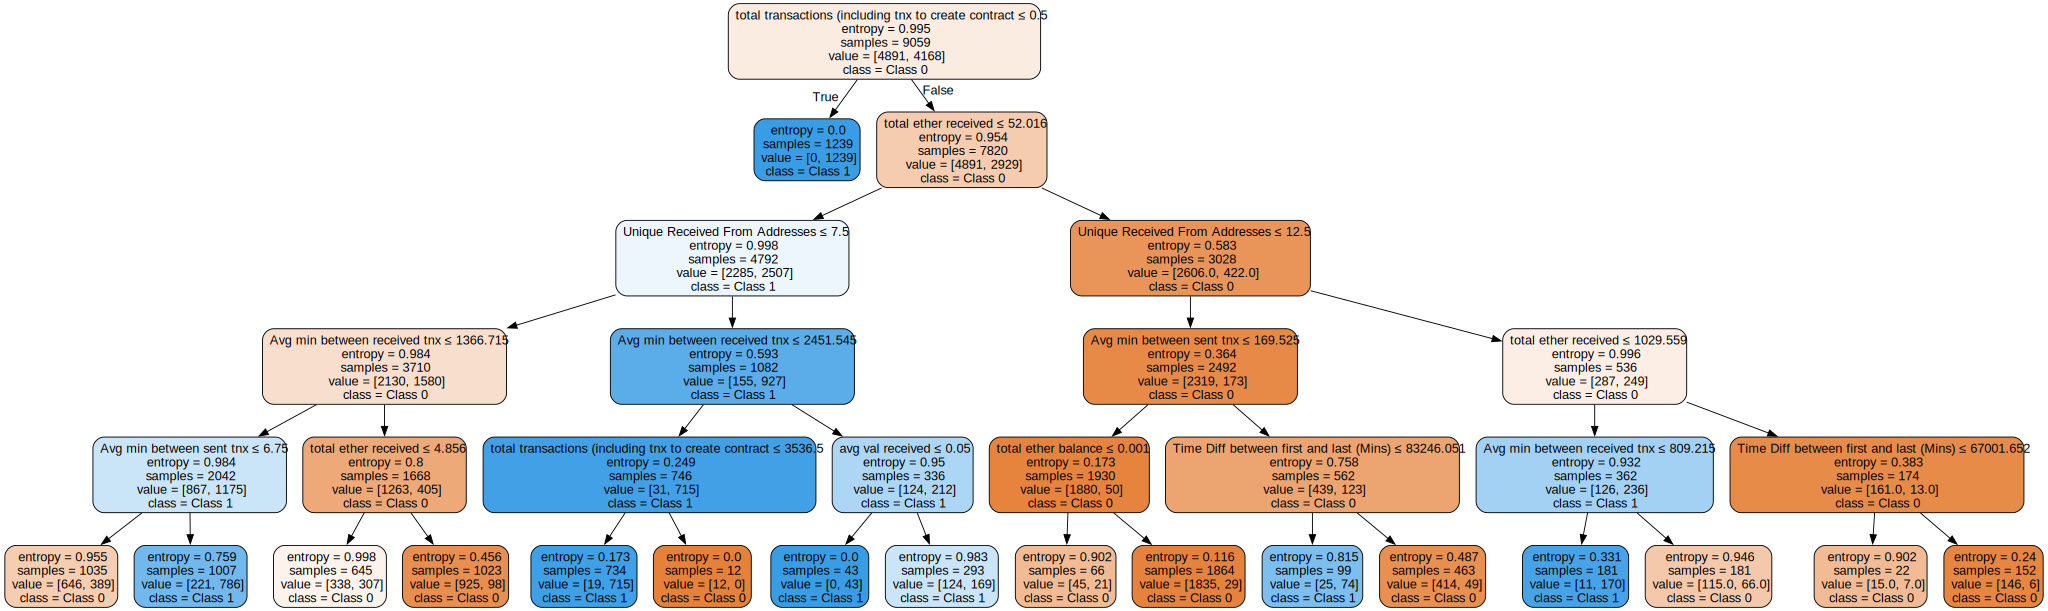

In [52]:
from sklearn.tree import export_graphviz
import graphviz

def visualize_tree(decision_tree, feature_names, class_names):
    """
    Visualizes the decision tree using graphviz.

    Parameters:
        decision_tree (DecisionTreeClassifier): The trained decision tree model.
        feature_names (list): List of feature names.
        class_names (list): List of class names.
    """
    dot_data = export_graphviz(
        decision_tree,
        out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    return graph
from sklearn.tree import DecisionTreeClassifier

# Train the model using scikit-learn
sklearn_model = DecisionTreeClassifier(max_depth=5, min_samples_split=4, criterion='entropy')
sklearn_model.fit(X_train, y_train)

# Visualize the decision tree
feature_names = X_features.tolist()
class_names = ['Class 0', 'Class 1']
graph = visualize_tree(sklearn_model, feature_names, class_names)
graph.render("decision_tree")  # Save the tree as a file
graph